In [ ]:
from google.colab import drive
drive.mount('/content/drive')

Mounted at /content/drive


In [ ]:
import os
import numpy as np
import tensorflow as tf
from tensorflow.keras.utils import to_categorical, load_img, img_to_array
from tensorflow.keras.layers import GlobalAveragePooling1D, Dense, Input, Lambda
from tensorflow.keras.models import Model
from sklearn.model_selection import train_test_split
from transformers import TFAutoModel

In [ ]:
# Dataset directory and class names
dataset_dir = "/content/drive/MyDrive/new clean"
class_names = ['Severe_cleaned', 'Unhealthy_cleaned', 'Unhealthy_for_Sensitive_Groups_cleaned', 'Very_Unhealthy_cleaned', 'good_cleaned', 'moderate_cleaned']

# Class name to label mapping
class_map = {class_name: idx for idx, class_name in enumerate(class_names)}

# List to store images and labels
images = []
labels = []

# Maximum number of images to load per class
max_images_per_class = 500  # Adjust this as needed

# Load images and labels
for class_name in class_names:
    class_folder = os.path.join(dataset_dir, class_name)
    counter = 0
    for filename in os.listdir(class_folder):
        if filename.endswith('.jpg') or filename.endswith('.png'):
            img_path = os.path.join(class_folder, filename)
            img = load_img(img_path, target_size=(224, 224))
            img_array = img_to_array(img)
            images.append(img_array)
            labels.append(class_map[class_name])
            counter += 1
            if counter >= max_images_per_class:
                break

# Convert images and labels to numpy arrays
images = np.array(images, dtype=np.float32) / 255.0  # Normalize images
labels = np.array(labels, dtype=np.int32)
labels = to_categorical(labels, num_classes=len(class_names))  # One-hot encode labels



In [ ]:
# Split data into training and test sets
X_train, X_test, y_train, y_test = train_test_split(images, labels, train_size=0.8, test_size=0.2, random_state=42)

# Further split training data into training and validation sets
X_train, X_val, y_train, y_val = train_test_split(X_train, y_train, test_size=0.2, random_state=42)

print(f"Train shape: {X_train.shape}, Validation shape: {X_val.shape}, Test shape: {X_test.shape}")


Train shape: (1920, 224, 224, 3), Validation shape: (480, 224, 224, 3), Test shape: (600, 224, 224, 3)


In [ ]:
# Load pretrained Vision Transformer (ViT) model
vit_model_name = "google/vit-base-patch16-224-in21k"
vit_model = TFAutoModel.from_pretrained(vit_model_name)


/usr/local/lib/python3.11/dist-packages/huggingface_hub/utils/_auth.py:94: UserWarning: 
The secret `HF_TOKEN` does not exist in your Colab secrets.
To authenticate with the Hugging Face Hub, create a token in your settings tab (https://huggingface.co/settings/tokens), set it as secret in your Google Colab and restart your session.
You will be able to reuse this secret in all of your notebooks.
Please note that authentication is recommended but still optional to access public models or datasets.
  warnings.warn(


config.json:   0%|          | 0.00/502 [00:00<?, ?B/s]

model.safetensors:   0%|          | 0.00/346M [00:00<?, ?B/s]

All PyTorch model weights were used when initializing TFViTModel.

All the weights of TFViTModel were initialized from the PyTorch model.
If your task is similar to the task the model of the checkpoint was trained on, you can already use TFViTModel for predictions without further training.


In [ ]:
# Define input for ViT
vit_input = Input(shape=(224, 224, 3), name="vit_input")

In [ ]:
# Resize and preprocess input for ViT
vit_preprocessed = Lambda(lambda x: tf.image.resize(x, (224, 224)), name="vit_resize")(vit_input)
vit_preprocessed_transposed = Lambda(lambda x: tf.transpose(x, perm=[0, 3, 1, 2]), name="vit_transpose")(vit_preprocessed)


In [ ]:
# Pass input through ViT
vit_output = Lambda(lambda x: vit_model(x, training=False).last_hidden_state, name="vit_output_layer")(vit_preprocessed_transposed)
vit_output = GlobalAveragePooling1D(name="vit_pooling")(vit_output)


In [ ]:
# Final dense layer for classification
final_output = Dense(len(class_names), activation='softmax', name="output_layer")(vit_output)

In [ ]:
# Define the model
model = Model(inputs=vit_input, outputs=final_output)

# Compile the model
model.compile(optimizer='adam', loss='categorical_crossentropy', metrics=['accuracy'])

print(model.summary())

Model: "functional"

┏━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━━━┓
┃ Layer (type)                         ┃ Output Shape                ┃         Param # ┃
┡━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━━━┩
│ vit_input (InputLayer)               │ (None, 224, 224, 3)         │               0 │
├──────────────────────────────────────┼─────────────────────────────┼─────────────────┤
│ vit_resize (Lambda)                  │ (None, 224, 224, 3)         │               0 │
├──────────────────────────────────────┼─────────────────────────────┼─────────────────┤
│ vit_transpose (Lambda)               │ (None, 3, 224, 224)         │               0 │
├──────────────────────────────────────┼─────────────────────────────┼─────────────────┤
│ vit_output_layer (Lambda)            │ (None, 197, 768)            │               0 │
├──────────────────────────────────────┼─────────────────────────────┼─────────────────┤
│ vit_pooling (GlobalAveragePooling1D) │ (None, 768)                 │               0 │
├──────────────────────────────────────┼─────────────────────────────┼─────────────────┤
│ output_layer (Dense)                 │ (None, 6)                   │           4,614 │
└──────────────────────────────────────┴─────────────────────────────┴─────────────────┘

 Total params: 4,614 (18.02 KB)

 Trainable params: 4,614 (18.02 KB)

 Non-trainable params: 0 (0.00 B)

None


In [ ]:
# Train the model
history = model.fit(
    X_train, y_train,
    validation_data=(X_val, y_val),
    batch_size=32,
    epochs=8
)

Epoch 1/8
60/60 ━━━━━━━━━━━━━━━━━━━━ 46s 555ms/step - accuracy: 0.4325 - loss: 1.5744 - val_accuracy: 0.7688 - val_loss: 1.0231
Epoch 2/8
60/60 ━━━━━━━━━━━━━━━━━━━━ 35s 533ms/step - accuracy: 0.7721 - loss: 0.9516 - val_accuracy: 0.8062 - val_loss: 0.7498
Epoch 3/8
60/60 ━━━━━━━━━━━━━━━━━━━━ 42s 549ms/step - accuracy: 0.8000 - loss: 0.7176 - val_accuracy: 0.8208 - val_loss: 0.6054
Epoch 4/8
60/60 ━━━━━━━━━━━━━━━━━━━━ 42s 559ms/step - accuracy: 0.8499 - loss: 0.5755 - val_accuracy: 0.8562 - val_loss: 0.5122
Epoch 5/8
60/60 ━━━━━━━━━━━━━━━━━━━━ 38s 504ms/step - accuracy: 0.8869 - loss: 0.4747 - val_accuracy: 0.8917 - val_loss: 0.4464
Epoch 6/8
60/60 ━━━━━━━━━━━━━━━━━━━━ 45s 567ms/step - accuracy: 0.9098 - loss: 0.4175 - val_accuracy: 0.9104 - val_loss: 0.3969
Epoch 7/8
60/60 ━━━━━━━━━━━━━━━━━━━━ 34s 569ms/step - accuracy: 0.9339 - loss: 0.3830 - val_accuracy: 0.9229 - val_loss: 0.3556
Epoch 8/8
60/60 ━━━━━━━━━━━━━━━━━━━━ 34s 566ms/step - accuracy: 0.9371 - loss: 0.3309 - val_accuracy: 0.

In [ ]:
# Extract training and validation loss
training_loss = history.history['loss'][-1]  # Training loss of the last epoch
validation_loss = history.history['val_loss'][-1]  # Validation loss of the last epoch

# Extract training and validation accuracy
training_accuracy = history.history['accuracy'][-1]  # Training accuracy of the last epoch
validation_accuracy = history.history['val_accuracy'][-1]  # Validation accuracy of the last epoch

# Testing loss and accuracy
test_loss, test_acc = model.evaluate(X_test, y_test, batch_size=32)

# Print the results
print(f"Training Loss: {training_loss:.4f}")
print(f"Validation Loss: {validation_loss:.4f}")
print(f"Testing Loss: {test_loss:.4f}")
print(f"Training Accuracy: {training_accuracy:.4f}")
print(f"Validation Accuracy: {validation_accuracy:.4f}")
print(f"Testing Accuracy: {test_acc:.4f}")


19/19 ━━━━━━━━━━━━━━━━━━━━ 17s 589ms/step - accuracy: 0.9470 - loss: 0.3044
Training Loss: 0.3248
Validation Loss: 0.3238
Testing Loss: 0.3193
Training Accuracy: 0.9349
Validation Accuracy: 0.9375
Testing Accuracy: 0.9383


In [ ]:
# Evaluate the model
train_accuracy = history.history['accuracy'][-1]  # Accuracy of the last epoch
print(f'Training Accuracy: {train_accuracy * 100:.2f}%')

Training Accuracy: 93.49%


In [ ]:
test_loss, test_acc = model.evaluate(X_test, y_test, batch_size=32)
print(f"Test Accuracy: {test_acc * 100:.2f}%")

19/19 ━━━━━━━━━━━━━━━━━━━━ 7s 375ms/step - accuracy: 0.9470 - loss: 0.3044
Test Accuracy: 93.83%


In [ ]:
# Save the model
model.save("vit_model.h5")

In [ ]:
# Generate and visualize the confusion matrix
from sklearn.metrics import confusion_matrix
import seaborn as sns
import matplotlib.pyplot as plt

In [ ]:
# Make predictions on the test set
y_pred = model.predict(X_test)
y_pred_class = np.argmax(y_pred, axis=1)  # Get the class predictions

19/19 ━━━━━━━━━━━━━━━━━━━━ 15s 653ms/step


In [ ]:
# Get the true labels (use the same class encoding as before)
y_true_class = np.argmax(y_test, axis=1)


In [ ]:
# Generate the confusion matrix
cm = confusion_matrix(y_true_class, y_pred_class)

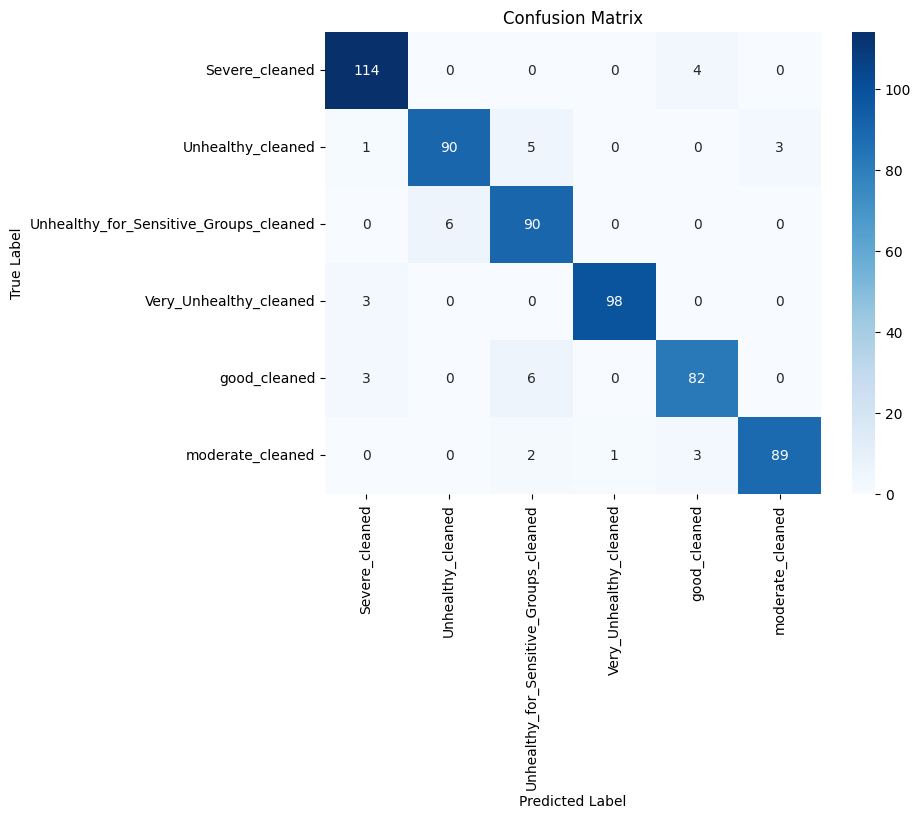

In [ ]:
# Plot the confusion matrix using seaborn heatmap
plt.figure(figsize=(8, 6))
sns.heatmap(cm, annot=True, fmt='d', cmap='Blues', xticklabels=class_names, yticklabels=class_names)
plt.title('Confusion Matrix')
plt.xlabel('Predicted Label')
plt.ylabel('True Label')
plt.show()


In [ ]:
from sklearn.metrics import classification_report, accuracy_score

# Calculate precision, recall, F1-score, and accuracy
report = classification_report(y_true_class, y_pred_class, target_names=class_names)
test_accuracy = accuracy_score(y_true_class, y_pred_class)

# Print the classification report
print("Classification Report:\n")
print(report)




Classification Report:

                                        precision    recall  f1-score   support

                        Severe_cleaned       0.94      0.97      0.95       118
                     Unhealthy_cleaned       0.94      0.91      0.92        99
Unhealthy_for_Sensitive_Groups_cleaned       0.87      0.94      0.90        96
                Very_Unhealthy_cleaned       0.99      0.97      0.98       101
                          good_cleaned       0.92      0.90      0.91        91
                      moderate_cleaned       0.97      0.94      0.95        95

                              accuracy                           0.94       600
                             macro avg       0.94      0.94      0.94       600
                          weighted avg       0.94      0.94      0.94       600



In [ ]:
from sklearn.metrics import precision_score, recall_score, f1_score

# Function to compute precision, recall, and F1 score
def compute_metrics(y_true, y_pred, class_names):
    y_true_class = np.argmax(y_true, axis=1)  # Convert one-hot to class labels
    y_pred_class = np.argmax(y_pred, axis=1)

    precision = precision_score(y_true_class, y_pred_class, average='weighted')
    recall = recall_score(y_true_class, y_pred_class, average='weighted')
    f1 = f1_score(y_true_class, y_pred_class, average='weighted')

    return precision, recall, f1



In [ ]:
# Predict for training data
y_train_pred = model.predict(X_train)
train_precision, train_recall, train_f1 = compute_metrics(y_train, y_train_pred, class_names)

# Predict for validation data
y_val_pred = model.predict(X_val)
val_precision, val_recall, val_f1 = compute_metrics(y_val, y_val_pred, class_names)

# Predict for testing data
y_test_pred = model.predict(X_test)
test_precision, test_recall, test_f1 = compute_metrics(y_test, y_test_pred, class_names)

# Print the metrics
print("\nTraining Metrics:")
print(f"Precision: {train_precision:.4f}, Recall: {train_recall:.4f}, F1 Score: {train_f1:.4f}")

print("\nValidation Metrics:")
print(f"Precision: {val_precision:.4f}, Recall: {val_recall:.4f}, F1 Score: {val_f1:.4f}")

print("\nTesting Metrics:")
print(f"Precision: {test_precision:.4f}, Recall: {test_recall:.4f}, F1 Score: {test_f1:.4f}")


60/60 ━━━━━━━━━━━━━━━━━━━━ 23s 386ms/step
15/15 ━━━━━━━━━━━━━━━━━━━━ 6s 399ms/step
19/19 ━━━━━━━━━━━━━━━━━━━━ 8s 401ms/step

Training Metrics:
Precision: 0.9490, Recall: 0.9484, F1 Score: 0.9485

Validation Metrics:
Precision: 0.9391, Recall: 0.9375, F1 Score: 0.9373

Testing Metrics:
Precision: 0.9393, Recall: 0.9383, F1 Score: 0.9385
